# Loading the dataset and importing libraries


Before running this notebook, we recommand you to activate the colaboratory GPU accelerator to increase the calculations performances.

In [3]:
import pandas as pd
import json
import numpy as np
from sklearn.preprocessing import scale, normalize, StandardScaler
from app import EvaluateAndReport, add_features, plot_features, to_RGB, get_distrib

# Importing Keras library from Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers.merge import Concatenate

In [4]:
# Import Google Drive
from google.colab import drive
drive.mount('/content/drive')

#returns JSON object as a dictionary
f = open('/content/drive/MyDrive/Iceberg/train.json',) # The train.json file needs to be in an "Iceberg" directory

# creating a dataframe
df_raw = pd.DataFrame(json.load(f))

# visualising the first rows
df_raw.head()

Mounted at /content/drive


,id,band_1,band_2,inc_angle,is_iceberg
0,dfd5f913,"[-27.878361, -27.15416, -28.668615, -29.537971...","[-27.154118, -29.537888, -31.0306, -32.190483,...",43.9239,0
1,e25388fd,"[-12.242375, -14.920305, -14.920363, -12.66633...","[-31.506321, -27.984554, -26.645678, -23.76760...",38.1562,0
2,58b2aaa0,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",45.2859,1
3,4cfc3a18,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",43.8306,0
4,271f93f4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",35.6256,0


In [5]:
# Visualising info
print(df_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1604 entries, 0 to 1603
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          1604 non-null   object
 1   band_1      1604 non-null   object
 2   band_2      1604 non-null   object
 3   inc_angle   1604 non-null   object
 4   is_iceberg  1604 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 62.8+ KB
None


In [6]:
# Train/test split
df = df_raw.sample(frac = 0.8, random_state = 42)
df_test = df_raw.drop(df.index)

In [7]:
# Changing inc_angle from object to float64
df.replace('na', np.NaN, inplace = True) # Replacing the 'na' text in inc_angle by NaN
df['inc_angle'].astype('float', copy = False) # Casting inc_angle to float works with the NaN
df[df.inc_angle.isna()] # 133 NaN
print(df.info()) # inc_angle is now float64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1283 entries, 530 to 546
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          1283 non-null   object 
 1   band_1      1283 non-null   object 
 2   band_2      1283 non-null   object 
 3   inc_angle   1175 non-null   float64
 4   is_iceberg  1283 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 60.1+ KB
None


# Creating the train dataset

In [11]:
X_b1=np.array(
    [np.array(band).astype(np.float64).reshape(75, 75) for band in df["band_1"]]
    )

X_b2=np.array(
    [np.array(band).astype(np.float64).reshape(75, 75) for band in df["band_2"]]
    )

X_train = np.concatenate([X_b1[:, :, :, np.newaxis], X_b2[:, :, :, np.newaxis]], axis=-1)

In [12]:
target_train=df['is_iceberg']

# Défintion des couches

In [36]:
model = keras.Sequential([
    # Pretraitement, 'data augmentation'
    preprocessing.RandomFlip('horizontal'), # flip gauche-à-droite

    ########################
    ## CONVOLUTIONAL BASE ##
    ########################

    # Premier block avec conv2D et MaxPooling
    layers.Conv2D(filters=32, kernel_size=5, activation="relu", padding='same', input_shape=[75, 75, 2]),
    layers.MaxPool2D(),
    layers.Dropout(0.3),

    # Deuxième block 
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),
    layers.Dropout(0.2),

    # Troisième block
    layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
    layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
    layers.MaxPool2D(),
    layers.Dropout(0.1),

    # Quatrième block 
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same'),
    layers.MaxPool2D(),
    layers.Dropout(0.1),

    # Applatissement des données les couches denses
    layers.Flatten(),

    ########################
    ##    DENSE HEAD      ##
    ########################

    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    # Activation Sigmoid pour le classifier
    layers.Dense(1, activation="sigmoid")
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

# Pour éviter de l'overfitting 
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=30, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [37]:
from sklearn.model_selection import train_test_split

X_train_cv, X_valid, y_train_cv, y_valid = train_test_split(X_train, target_train, random_state=42, train_size=0.75)

# Entrainement du modèle

In [38]:
history = model.fit(
    X_train_cv, y_train_cv,
    validation_data=(X_valid, y_valid),
    batch_size=20,
    epochs=100,
    callbacks=[early_stopping],
)

Epoch 1/100
49/49 [==============================] - 4s 41ms/step - loss: 0.7499 - binary_accuracy: 0.5301 - val_loss: 1.1114 - val_binary_accuracy: 0.4891
Epoch 2/100
49/49 [==============================] - 2s 32ms/step - loss: 0.7296 - binary_accuracy: 0.5229 - val_loss: 0.9556 - val_binary_accuracy: 0.4891
Epoch 3/100
49/49 [==============================] - 2s 32ms/step - loss: 0.6933 - binary_accuracy: 0.5613 - val_loss: 0.7186 - val_binary_accuracy: 0.5327
Epoch 4/100
49/49 [==============================] - 2s 32ms/step - loss: 0.7031 - binary_accuracy: 0.5582 - val_loss: 0.7693 - val_binary_accuracy: 0.5826
Epoch 5/100
49/49 [==============================] - 2s 32ms/step - loss: 0.6923 - binary_accuracy: 0.5624 - val_loss: 0.8894 - val_binary_accuracy: 0.5888
Epoch 6/100
49/49 [==============================] - 2s 31ms/step - loss: 0.6987 - binary_accuracy: 0.5561 - val_loss: 1.0060 - val_binary_accuracy: 0.5047
Epoch 7/100
49/49 [==============================] - 2s 32ms/ste

Minimum Validation Loss: 0.3091
Maximum Validation Accuracy: 0.8629


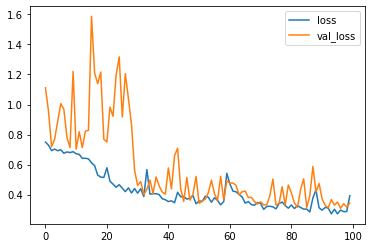

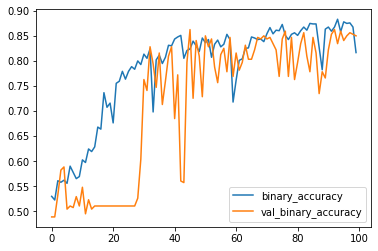

In [39]:
history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print(("Minimum Validation Loss: {:0.4f}").format(history_df['val_loss'].min()))
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();
print(("Maximum Validation Accuracy: {:0.4f}").format(history_df['val_binary_accuracy'].max()))